# Decreasing returns - Cobb Douglas

## Checking the phenomenon

In [1]:
import numpy as np
import scipy.stats as sst

In [2]:
np.random.seed(1337)

DISTRIBUTIONS = {
    'exponential': sst.expon,
    'gamma (a = 3)': sst.gamma(3),
    'half normal': sst.halfnorm,
    'pareto (b = 3)': sst.pareto(3),
    'pareto (b = 4)': sst.pareto(4),
    'uniform': sst.uniform
}

cumul_projects_by_dist = {}
for dn, d in DISTRIBUTIONS.iteritems():
    projects = d.rvs(size=(2, 1000000))
    projects /= np.sum(projects, axis=-1, keepdims=True) # normalizing for easier comparison
    roi = projects[0] / projects[1]
    sorted_by_roi_idx = np.argsort(-roi)
    projects = projects[:, sorted_by_roi_idx]
    cumul_projects_by_dist[dn] = np.cumsum(projects, axis=1)

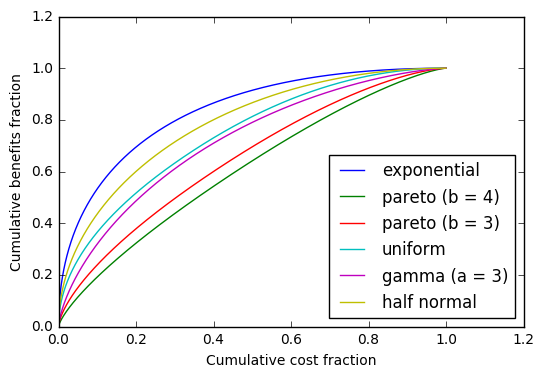

In [3]:
import matplotlib.pyplot as plt
plt.clf()
for dn, dcp in cumul_projects_by_dist.iteritems():
    plt.plot(dcp[1], dcp[0], label=dn)
plt.xlabel('Cumulative cost fraction')
plt.ylabel('Cumulative benefits fraction')
plt.legend(loc='lower right')
plt.show()

I am not sure if there is any phenomenon to explain. If we call the normalized curve $B(C)$ and our source joint distribution

  * has support in $[0, +\infty)^2$ and
  * significant mass distributed next to both axes,

$B(C)$ will have the following properties:

  * $B''(C) < 0$ (just because we are sorting by decreasing ROI)
  * $\lim_{C\to 0} B'(C) = +\infty$ (significant probability mass next to $c = 0$ with many different values of $b$)
  * $\lim_{C\to 1} B'(C) = 0$ (significant probability mass next to $b = 0$ with many different values of $c$).
  * $B(0) = 0$ and $B(1) = 1$ (because we normalize).

Given those properties, I think the observed functions are reasonably generic.

## Creating a distribution - constant costs

We can start by imagining the discrete and deterministic version of the problem: we want to approximate a given $B(C)$ function by using $N$ projects. The easiest way will be to make them all of unit cost and to give the $i$-th one a benefit $B(i/N)-B((i-1)/N)$.

The associated probabilistic version is putting $1/N$ of a Dirac delta at $b = B(i/n)-B((i-1)/n)$ for every $i$ between 1 and $N$. In the continuous version, we want the distribution of values of $B'(C)$ assuming an uniform distribution for $C$. Then:

$\displaystyle f_{B'}(B'(c_0)) \approx \frac{1}{\epsilon} P(B'(c_0) \le B'(c) \le B'(c_0) + \epsilon)$

$\displaystyle \approx \frac{1}{\epsilon} P(B'(c_0) \le B'(c) \le B'(c_0 + B''(c_0)^{-1}\epsilon))$

$\displaystyle \approx \frac{1}{\epsilon} \left|\,B''(c_0)^{-1}\,\right|\epsilon$

$\displaystyle \approx \left|\,B''(c_0)^{-1}\,\right|$

leading to

$\displaystyle f_{B'}(x) = \left|\,B''\left((B')^{-1}(x)\right)^{-1}\,\right|$.

So then, if we make

$\displaystyle f_\mathrm{Benefits}(x) = \left|\,B''\left((B')^{-1}(x)\right)^{-1}\,\right|$ and

$\displaystyle f_\mathrm{Costs}(x) = \delta(x - 1)$,

then $B(C)$ will have the desired distribution.

### Example

Starting with a very simple example, $B(C) = 1 - (C - 1)^2$,

$\displaystyle B'(x) = -2(x - 1) = 2 - 2x$

$\displaystyle B''(x) = -2$

$\displaystyle B'((B')^{-1}(x)) = x$

$\displaystyle -2((B')^{-1}(x)) + 2 = x$

$\displaystyle 2((B')^{-1}(x)) = 2 - x$

$\displaystyle (B')^{-1}(x) = \frac{2 - x}{2}$.

So we should select values of the benefits in the range $[0, 2]$ uniformly.

Testing it:

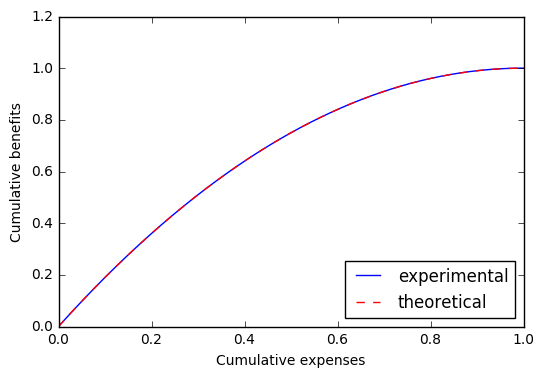

In [4]:
np.random.seed(1337)
benefits = np.random.uniform(low=0, high=2, size=1000000)
costs = np.ones(shape=1000000)
roi = benefits / costs
sorted_by_roi_idx = np.argsort(-roi)
cumul_benefits = np.cumsum(benefits[sorted_by_roi_idx]) / 10**6
cumul_costs = np.cumsum(costs[sorted_by_roi_idx]) / 10**6
x = np.linspace(0, 1, 1000)
plt.clf()
plt.plot(cumul_costs, cumul_benefits, 'b-', label='experimental')
plt.plot(x, 1 - (x - 1)**2, 'r--', label='theoretical')
plt.xlabel('Cumulative expenses')
plt.ylabel('Cumulative benefits')
plt.legend(loc='lower right')
plt.show()

Now for a more nontrivial example,

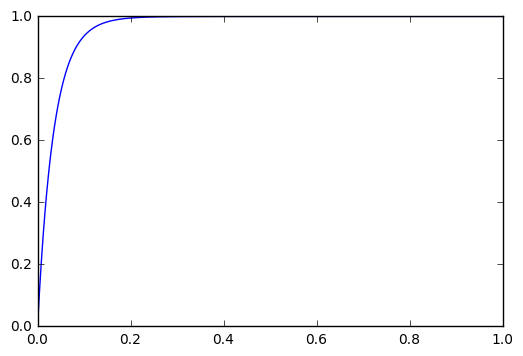

In [5]:
x = np.linspace(0, 1, 1000)
y = 1.0 - (x + 1.)**(-29)
plt.clf()
plt.plot(x, y)
plt.show()

$\displaystyle B(C) = 1 - (1 + x)^{-29}$ (the constant is not exact... but it doesn't matter)

$\displaystyle B'(x) = 29(1 + x)^{-30}$

$\displaystyle B''(x) = -30\cdot 29(1 + x)^{-31}$

$\displaystyle = -870(1 + x)^{-31}$

$\displaystyle B'((B')^{-1}(x)) = x$

$\displaystyle 29(1 + (B')^{-1}(x))^{-30} = x$

$\displaystyle (1 + (B')^{-1}(x))^{-30} = \frac{x}{29}$

$\displaystyle 1 + (B')^{-1}(x) = \left(\frac{x}{29}\right)^{-\frac{1}{30}}$

$\displaystyle (B')^{-1}(x) = \left(\frac{x}{29}\right)^{-\frac{1}{30}} - 1$

Putting it together:

$\displaystyle \left|B''((B')^{-1}(x))\right| = \left|-870\left(1 + \left(\left(\frac{x}{29}\right)^{-\frac{1}{30}} - 1\right)\right)^{-31}\right|$

$\displaystyle = \left|-870\left(1 + \left(\left(\frac{x}{29}\right)^{-\frac{1}{30}} - 1\right)\right)^{-31}\right|$

$\displaystyle = \left|-870\left(\left(\frac{x}{29}\right)^{-\frac{1}{30}}\right)^{-31}\right|$

$\displaystyle = \left|-870\left(\frac{x}{29}\right)^{\frac{31}{30}}\right|$

Density:

$\displaystyle f(x) = \frac{\frac{1}{870}}{\left(\frac{x}{29}\right)^{\frac{31}{30}}}$

$\displaystyle = \frac{\frac{29^\frac{31}{30}}{870}}{x^\frac{31}{30}}$

Range of the derivative:

$\displaystyle \left[29(1 + 1)^{-30}, 29(1 + 0)^{-30}\right] = \left[29\cdot 2^{-30}, 29\right]$

Testing the distribution:

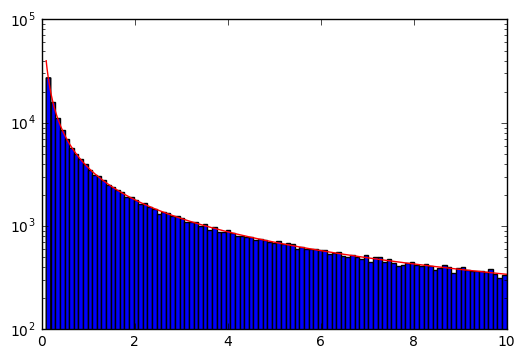

In [6]:
np.random.seed(1337)
benefits = sst.pareto.rvs(b=1./30, scale=29*2**-30., size=2000000)
benefits = benefits[benefits<29.][:10**6]
x = np.linspace(0.1, 10, 1000)
eb = (1.0 / 870.0) * ((x / 29.) ** (-31./30.)) * 10**6 * 9.9 / 100
plt.clf()
plt.hist(benefits, bins=100, range=[0.1, 10], log=True)
plt.plot(x, eb, 'r-')
plt.show()

Checking if it matches:

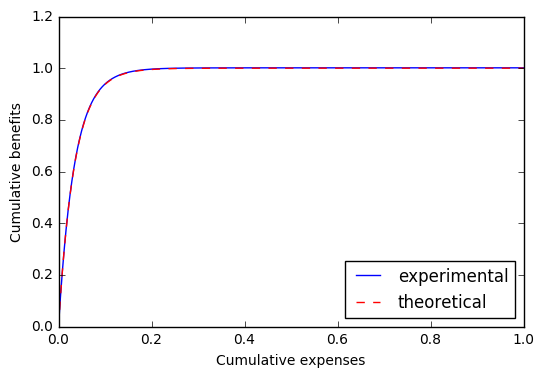

In [7]:
costs = np.ones(shape=1000000)
roi = benefits / costs
sorted_by_roi_idx = np.argsort(-roi)
cumul_benefits = np.cumsum(benefits[sorted_by_roi_idx]) / 10**6
cumul_costs = np.cumsum(costs[sorted_by_roi_idx]) / 10**6
x = np.linspace(0, 1, 1000)
plt.clf()
plt.plot(cumul_costs, cumul_benefits, 'b-', label='experimental')
plt.plot(x, 1.0 - (x + 1.)**(-29), 'r--', label='theoretical')
plt.xlabel('Cumulative expenses')
plt.ylabel('Cumulative benefits')
plt.legend(loc='lower right')
plt.show()